In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from scipy.spatial import distance_matrix

from helpers import compute_proportion_of_votes

## Load data

We load data. We have two `DataFrame`s: `df_t1` and `df_t2`, corresponding respectively to the results of the first and second rounds of elections.

In [2]:
df_t1 = pd.read_csv('../data/presidentielle_t1.csv', low_memory=False)
df_t2 = pd.read_csv('../data/presidentielle_t2.csv', low_memory=False)

In [3]:
id_columns = [
    'CodeDepartement',
    'NomDepartement',
    'CodeCirconscription',
    'NomCirconscription',
    'CodeCommune',
    'NomCommune',
    'CodeBureauVote',
    'Inscrits']

choices_t1 = [
    'No_One',
    'Arthaud',
    'Roussel',
    'Macron',
    'Lassalle',
    'Le_Pen',
    'Zemmour',
    'Melenchon',
    'Hidalgo',
    'Jadot',
    'Pecresse',
    'Poutou',
    'Dupont_Aignan']

choices_t2 = [
    'No_One',
    'Macron',
    'Le_Pen']

## Data description

Each row represents a voting station which is identified by its location and the number of registered voters.

In [4]:
df_t1[id_columns].head()

,CodeDepartement,NomDepartement,CodeCirconscription,NomCirconscription,CodeCommune,NomCommune,CodeBureauVote,Inscrits
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,645
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1129
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1128
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213


We get the corresponding number of votes for each candidate. `No_One` corresponds to blank, invalid ballots and not casting a ballot (abstention). 

In [5]:
df_t1[choices_t1].head()

,No_One,Arthaud,Roussel,Macron,Lassalle,Le_Pen,Zemmour,Melenchon,Hidalgo,Jadot,Pecresse,Poutou,Dupont_Aignan
0,125,3,6,150,18,149,43,66,5,30,26,3,21
1,42,2,7,50,10,23,14,41,3,10,8,3,0
2,289,4,30,159,24,237,69,216,15,25,40,8,13
3,286,6,13,201,19,210,68,194,19,46,42,4,20
4,264,8,18,229,28,227,74,227,16,65,35,3,19


We look at the number of registered voters and voting stations by the department. 

We note that departments with a number corresponding to metropolitan France. Departments starting with 'Z' correspond to are located outside of France ('ZZ').

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print((df_t1.groupby(["CodeDepartement", "NomDepartement"]).
    Inscrits.
    agg(["count", "sum"]).
    rename(columns={"count": "N_Stations",
                    "sum": "N_Voters"})))

                                                 N_Stations  N_Voters
CodeDepartement NomDepartement                                       
01              Ain                                     584    438109
02              Aisne                                   974    373544
03              Allier                                  452    249991
04              Alpes-de-Haute-Provence                 263    128075
05              Hautes-Alpes                            207    113519
06              Alpes-Maritimes                         981    778582
07              Ardèche                                 439    255859
08              Ardennes                                560    186197
09              Ariège                                  379    119039
10              Aube                                    534    205551
11              Aude                                    586    279927
12              Aveyron                                 439    219468
13              Bouc

In [7]:
df_t1

,CodeDepartement,NomDepartement,CodeCirconscription,NomCirconscription,CodeCommune,NomCommune,CodeBureauVote,Inscrits,Abstentions,Votants,...,Macron,Lassalle,Le_Pen,Zemmour,Melenchon,Hidalgo,Jadot,Pecresse,Poutou,Dupont_Aignan
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,645,108,537,...,150,18,149,43,66,5,30,26,3,21
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213,38,175,...,50,10,23,14,41,3,10,8,3,0
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1129,266,863,...,159,24,237,69,216,15,25,40,8,13
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1128,265,863,...,201,19,210,68,194,19,46,42,4,20
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213,246,967,...,229,28,227,74,227,16,65,35,3,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69677,ZZ,Français établis hors de France,6,6ème circonscription,229,Zurich,0001,24868,14101,10767,...,5756,118,474,726,1475,269,993,580,47,189
69678,ZZ,Français établis hors de France,11,11ème circonscription,231,Taipei,0001,1709,942,767,...,286,11,29,105,176,12,82,33,10,10
69679,ZZ,Français établis hors de France,11,11ème circonscription,233,Nour-Soultan,0001,117,64,53,...,25,1,3,7,9,0,4,0,0,1
69680,ZZ,Français établis hors de France,2,2ème circonscription,234,Monterrey,0001,713,553,160,...,96,1,4,18,19,2,10,5,1,1


We have several voting stations that have no registered voters or did not cast a single valid vote for a candidate. We will remove these stations from further analysis.

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_t1.query('Inscrits == No_One')[["NomCommune",
                                              "Inscrits", "Votants",
                                              "No_One", "Abstentions"]])

                  NomCommune  Inscrits  Votants  No_One  Abstentions
669                    Besmé       113       93     113           20
683              Blérancourt       867      640     867          227
1054                    Laon       164        0     164          164
2083         Digne-les-Bains         0        0       0            0
2358                     Gap         1        0       1            1
2850                  Grasse      1142      864    1142          278
3188                    Nice       931      494     931          437
3695                  Privas        31        0      31           31
4017    Charleville-Mézières         0        0       0            0
4589                    Foix        17        0      17           17
6255                   Rodez        24        0      24           24
8744                Aurillac         0        0       0            0
9046               Angoulême        21        0      21           21
11200                Cargèse      

We see that there are four main choices in the first round: No Candidate, Macron, Le Pen, and Mélenchon. People polarized around these three candidates. Not many people went to the voting booth to cast a blank or invalid ballot.

In [9]:
(df_t1[choices_t1].sum(axis=0) / df_t1["Inscrits"].sum(axis=0)).sort_values(ascending=False)

No_One           0.279293
Macron           0.200687
Le_Pen           0.166855
Melenchon        0.158212
Zemmour          0.050981
Pecresse         0.034443
Jadot            0.033393
Lassalle         0.022594
Roussel          0.016461
Dupont_Aignan    0.014876
Hidalgo          0.012646
Poutou           0.005516
Arthaud          0.004043
dtype: float64

Le Pen voters didn't seem to do more numerous than people that didn't choose anyone. 

In [10]:
(df_t2[choices_t2].sum(axis=0) / df_t2["Inscrits"].sum(axis=0)).sort_values(ascending=False)

Macron    0.384979
No_One    0.342445
Le_Pen    0.272575
dtype: float64

## Format data

We only keep voting stations with at least 30 valid votes in both elections. We will compute the relative proportion of each candidate for these voting stations.

In [17]:
# filter
mask = ((df_t1["Votants"] - df_t1["No_One"] >= 30) & 
    (df_t2["Votants"] - df_t2["No_One"] >= 30))
df_t1 = df_t1.loc[mask,:].reset_index(drop=True)
df_t2 = df_t2.loc[mask,:].reset_index(drop=True)

# compute proportions
prop_t1 = compute_proportion_of_votes(df_t1, choices_t1)
prop_t2 = compute_proportion_of_votes(df_t2, choices_t2)

prop_t1.head(3)

,No_One,Arthaud,Roussel,Macron,Lassalle,Le_Pen,Zemmour,Melenchon,Hidalgo,Jadot,Pecresse,Poutou,Dupont_Aignan
0,0.193798,0.004651,0.009302,0.232558,0.027907,0.231008,0.066667,0.102326,0.007752,0.046512,0.040310,0.004651,0.032558
1,0.197183,0.009390,0.032864,0.234742,0.046948,0.107981,0.065728,0.192488,0.014085,0.046948,0.037559,0.014085,0.000000
2,0.255979,0.003543,0.026572,0.140833,0.021258,0.209920,0.061116,0.191320,0.013286,0.022143,0.035430,0.007086,0.011515


## PCA

We run PCA on first-round results. We plot the first two principal components and color points (voting booths) with proportional results for each candidate.

We find four "poles" that seem to be defined by the four main choices: Macron, Le Pen, Mélenchon, and Abstention. Pécresse voters seem to cluster with Macron voters and Jadot voters seem to be in between Mélenchon and Macron.

In [12]:
pca_t1 = PCA(n_components=2)
pca_t1.fit(prop_t1.apply(lambda x: (x - x.mean()) / x.std(), axis=0))
pca_df_t1 = pca_t1.transform(prop_t1)
pca_df_t1 = pd.DataFrame(pca_df_t1)
pca_df_t1.columns = ["PC" + str(x+1) for x in range(pca_df_t1.shape[1])]
pca_df_t1 = pd.concat([prop_t1, pca_df_t1], axis=1)

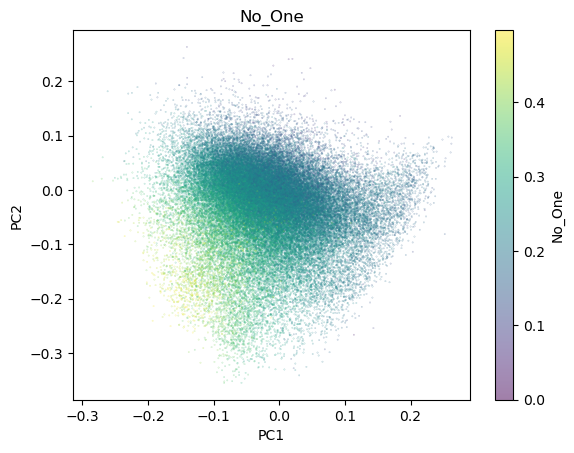

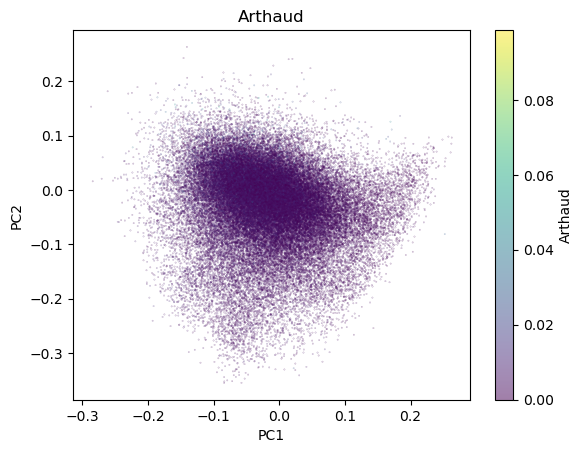

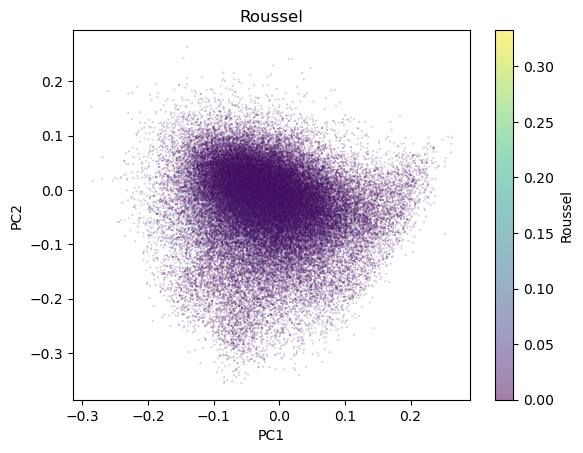

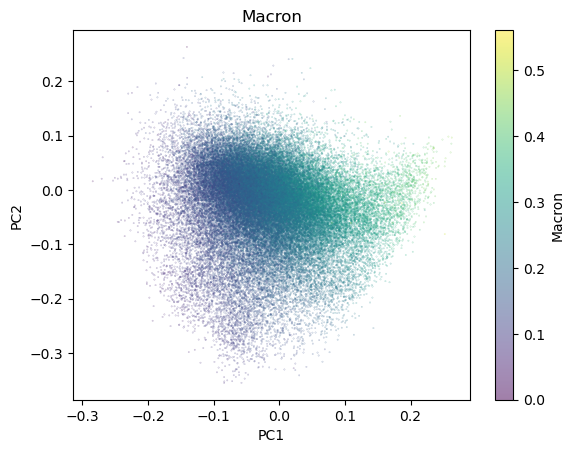

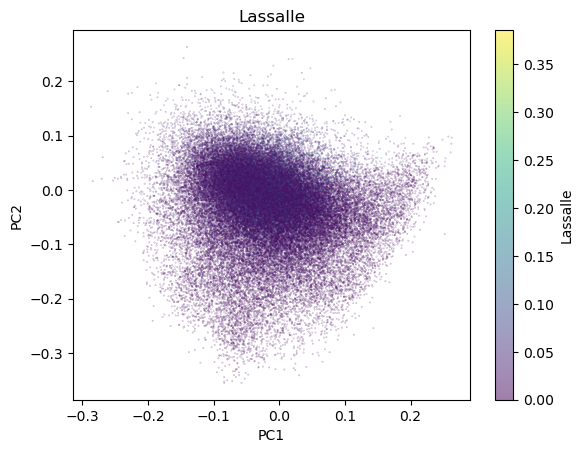

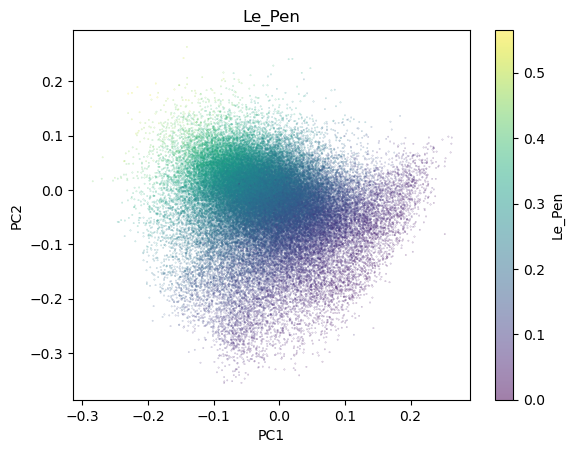

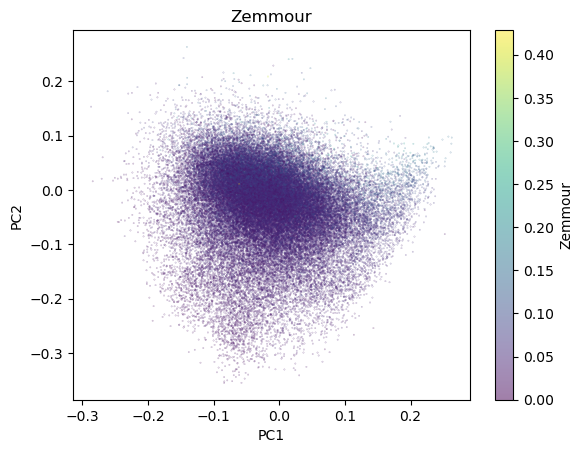

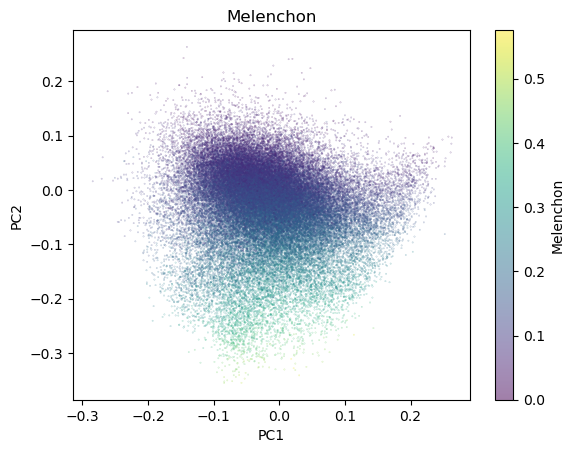

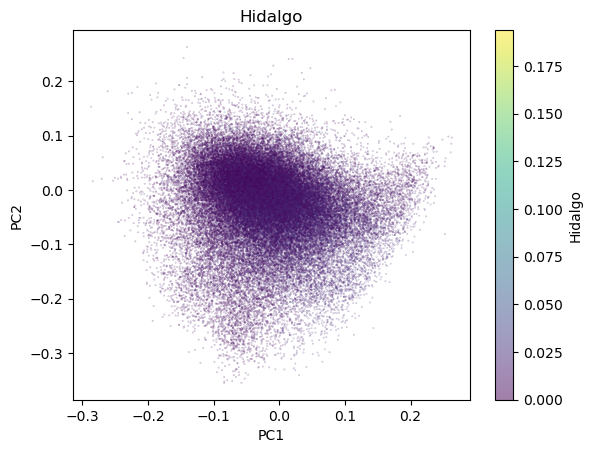

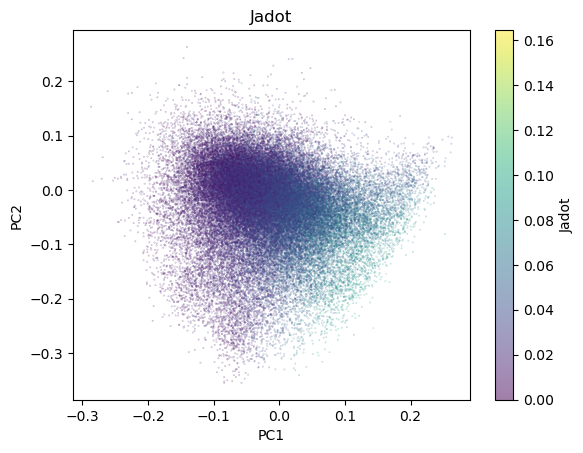

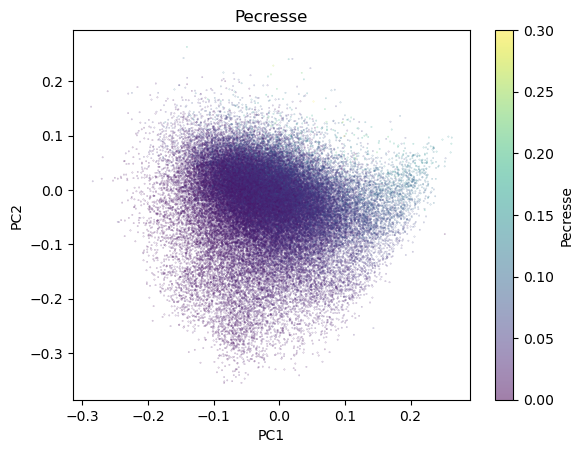

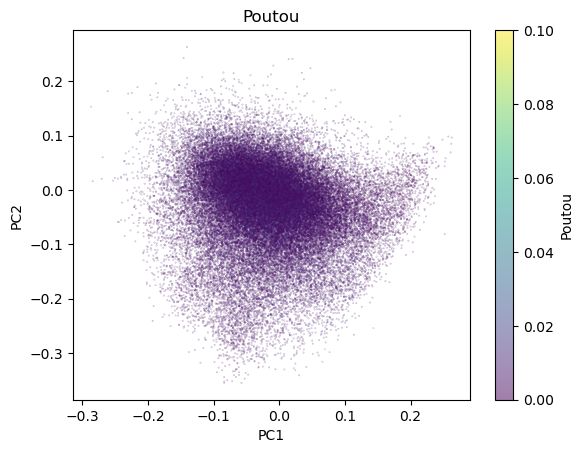

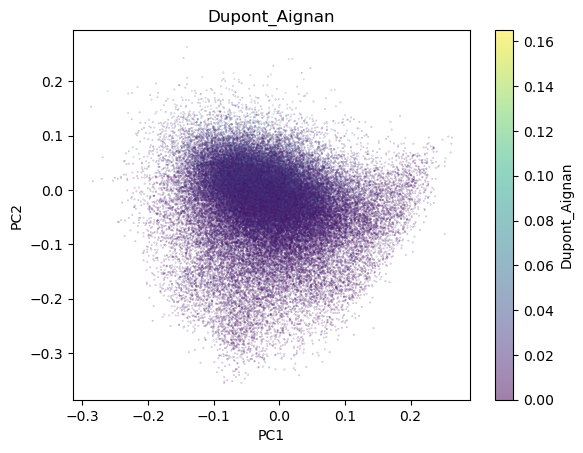

In [13]:
for candicat in choices_t1: 
    pca_df_t1.plot.scatter("PC1", "PC2", s=.05, c=candicat, alpha=.5)
    plt.title(candicat)

We repeat the same analysis in the second round. We find the same poles (except Mélenchon who did not pass to the second round).

In [14]:
pca_t2 = PCA(n_components=2)
pca_t2.fit(prop_t2.apply(lambda x: (x - x.mean()) / x.std(), axis=0))
pca_df_t2 = pca_t2.transform(prop_t2)
pca_df_t2 = pd.DataFrame(pca_df_t2)
pca_df_t2.columns = ["PC" + str(x+1) for x in range(pca_df_t2.shape[1])]
pca_df_t2 = pd.concat([prop_t2, pca_df_t2], axis=1)

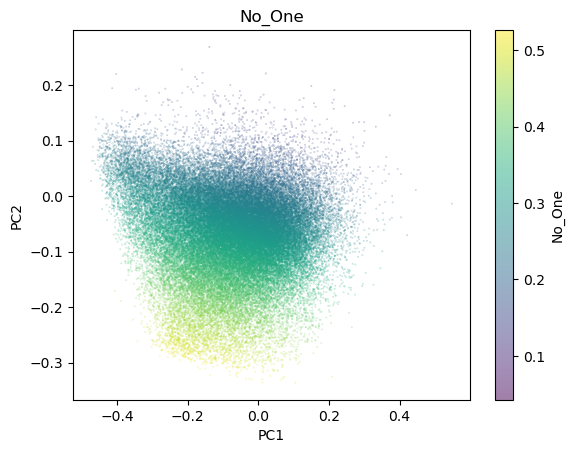

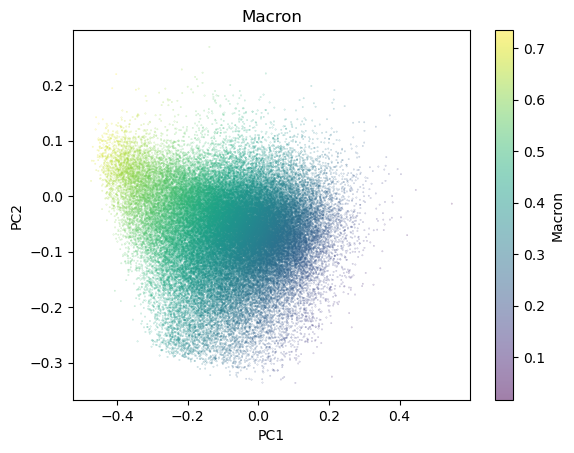

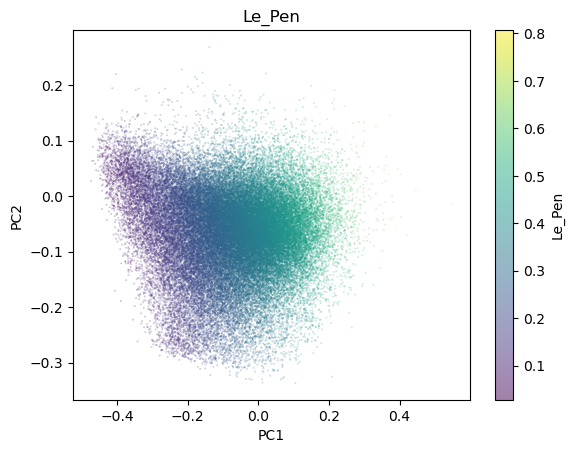

In [15]:
for candicat in choices_t2: 
    pca_df_t2.plot.scatter("PC1", "PC2", s=.05, c=candicat, alpha=.5)
    plt.title(candicat)

## Hierarchical Clustering using Correlation Matrix

This suggests three clusters:

- Cluster 1: Mélenchon and other left-wing candidates.
- Cluster 2: Macron, Jadot, Zémmour, Pécresse
- Cluster 3: Le Pen, Lassalle, Dupont-Aignat

Overall the cohesion of these clusters is quite low.

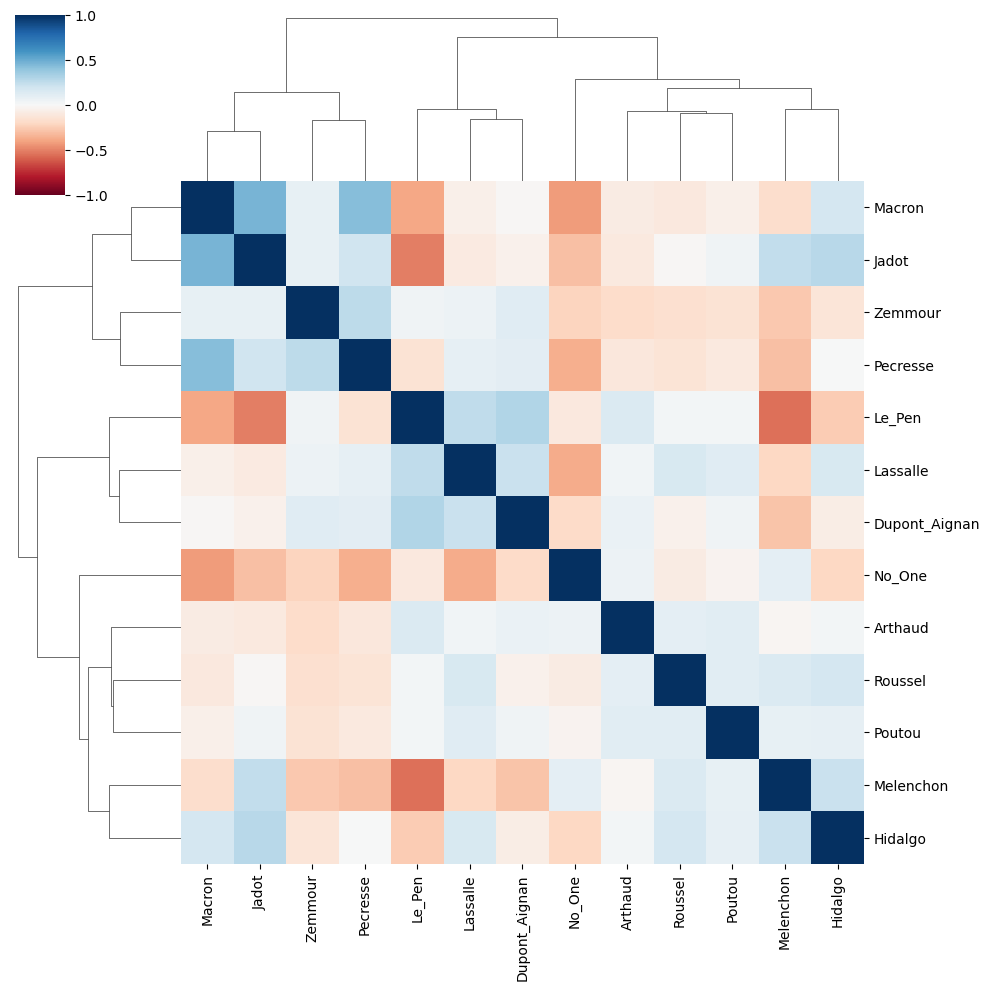

In [18]:
corr_prop_t1 = prop_t1.corr('spearman')

corr_prop_t1 = pd.DataFrame(corr_prop_t1)
corr_prop_t1.index = prop_t1.columns
corr_prop_t1.columns = prop_t1.columns

linkage = hc.linkage(hc.distance.pdist(corr_prop_t1), method='ward')
sns.clustermap(corr_prop_t1, cmap="RdBu", row_linkage=linkage, col_linkage=linkage, vmin=-1)